# 01 - News articles to Embeddings

We preprocess the data and create the following embeddings here:

- Beto (Spanish trained version of BERT)
- Elmo
- FastText

In [1]:
# Import libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from os.path import join, exists
from IPython.display import clear_output
from collections import Counter
from skmultilearn.model_selection import IterativeStratification
from scipy.stats import percentileofscore

In [2]:
# Download nltk files
nltk.download('punkt')
clear_output()

# Load, pre-process, and create the vocabulary

In [3]:
# Load dataset
df = pd.read_csv('NewsInformation.csv')

# Load each news article associated to each df's row.
def load_text(code):
    text_path = join('TXT', "{}.txt".format(code))
    if not exists(text_path):
        return "None"
    try:
        with open(text_path, encoding="UTF-8") as file:
            return file.read().replace("\r", "").replace("\n", " ")
    except:
        with open(text_path, encoding="latin-1") as file:
            return file.read().replace("\r", "").replace("\n", " ")

df["original_text"] = df.code.map(load_text)

# Filter None
df = df[df["original_text"] != "None"]

# Apply tokenization and lower case to the text
tkr = RegexpTokenizer('[a-zA-Z0-9áéíóú]+')
df['text'] = df['original_text'].apply(lambda text: " ".join([t for t in tkr.tokenize(text) ]).lower() )

# Keep frames as a list
df['frames'] = [np.array(x) for x in zip(df.conflict_fr.tolist(), df.econ_fr.tolist(), df.humint_fr.tolist(), df.morality_fr.tolist()) ]

# Rename and check the dataframe
df = df[['original_text', 'text', 'frames']]
df.head()

,original_text,text,frames
0,Japón registró un nuevo déficit comercial réco...,japón registró un nuevo déficit comercial réco...,"[0, 1, 0, 0]"
1,"UDI acusa ""mala memoria"" de la Nueva Mayoría f...",udi acusa mala memoria de la nueva mayoría fre...,"[1, 0, 0, 1]"
2,La misteriosa oferta por Esteban Paredes que i...,la misteriosa oferta por esteban paredes que i...,"[1, 0, 0, 0]"
3,La familia maratón que causó revuelo en Holand...,la familia maratón que causó revuelo en holand...,"[0, 0, 1, 0]"
4,Crean sitio web que recopila mangas descontin...,crean sitio web que recopila mangas descontinu...,"[0, 1, 0, 0]"


In [4]:
# Calculate words' frequency
word_list = []
word_doc_counter = {}

for _, row in df.iterrows():
    text = row.text.split()

    new_text = []
    for word in text:
        if word.isnumeric():
            new_text.append("[NUM]")
        else:
            new_text.append(word)

    word_list.extend(new_text)
    
    for word in set(new_text): # Unique words
        if word not in word_doc_counter:
            word_doc_counter[word] = 0
        word_doc_counter[word] += 1

counter = Counter(word_list)

In [5]:
# Number of unique words. 
# Words were counted only once within the text. Frequency is calculated among all documents. 
n_words = list(word_doc_counter.values())
len(n_words)

54996

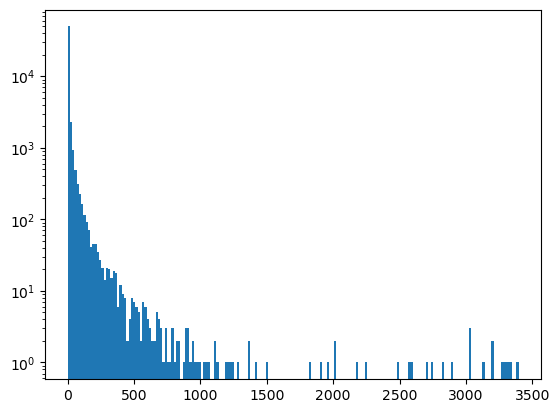

In [6]:
# Word distribution
plt.hist(n_words, bins=200,log=(True,True))
plt.show()

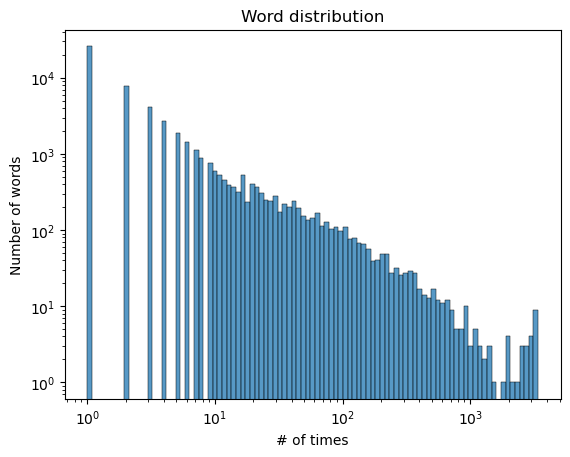

In [7]:
# Histogram 
g = sns.histplot(data=n_words,log_scale=(True,True))
g.set_title('Word distribution')
g.set_xlabel('# of times')
g.set_ylabel('Number of words')
plt.savefig('plots/word_distribution.svg', format='svg')
plt.show()

In [8]:
# Calculate percentile of these words
for i in range(1, 10):
    print(str(i) + ": " + str(percentileofscore(n_words, i)))

1: 23.527165612044513
2: 54.164848352607464
3: 64.99836351734672
4: 71.16608480616772
5: 75.34093388610081
6: 78.35660775329114
7: 80.6640482944214
8: 82.49327223798095
9: 83.99792712197251


In [9]:
# We keep words that appear five or more times.
K = 5
vocabulary = [(word, count) for word, count in counter.items() if word_doc_counter[word] >= K]
filtered_n_words = [count for word, count in counter.items() if word_doc_counter[word] >= K]

In [10]:
# Sort words by their frequency (bigger to smaller)
vocabulary.sort(key=lambda x:x[1])

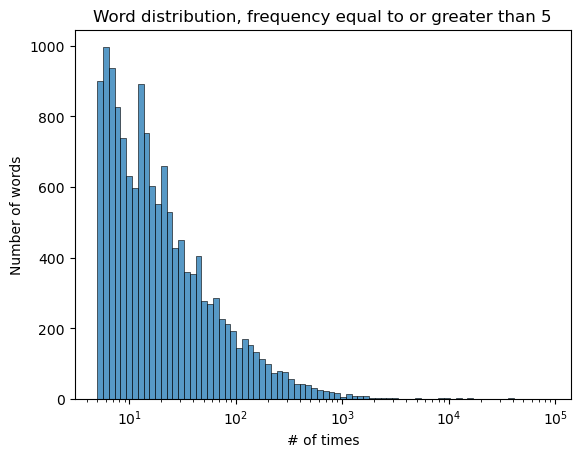

In [11]:
# Histogram 
g = sns.histplot(data=filtered_n_words, log_scale=True)
g.set_title('Word distribution, frequency equal to or greater than 5')
g.set_xlabel('# of times')
g.set_ylabel('Number of words')
plt.savefig('plots/word_distribution_after_5.svg', format='svg')
plt.show()

In [12]:
# Percentage of the vocabulary that stays
10000/len(filtered_n_words)

0.68903741473162

In [13]:
# Keep only the first 10,000 most frequent terms
# The list is ascendent, so we keep the last 10,000 elements.
vocabulary = vocabulary[-10000:]

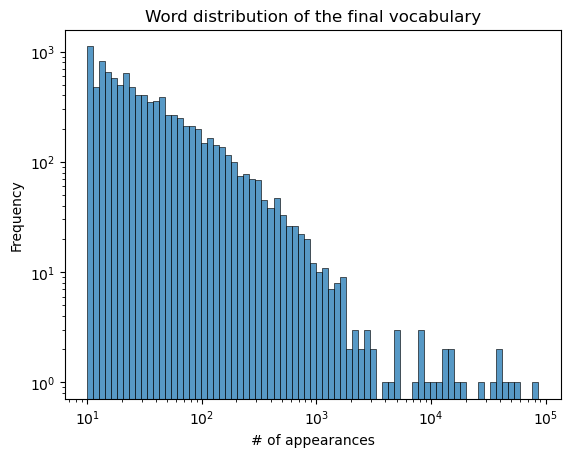

In [14]:
# Histogram 
final_words = [count for word, count in vocabulary]
g = sns.histplot(data=final_words, log_scale=(True,True))
g.set_title('Word distribution of the final vocabulary')
g.set_xlabel('# of appearances')
g.set_ylabel('Frequency')
plt.savefig('plots/word_distribution_vocabulary.svg', format='svg')
plt.show()

In [15]:
# Create corpus
with open("vocabulary_corpus_counter.txt", "w", encoding="utf-8") as file:
    for word, count in vocabulary:
        file.write(f"{word}: {count}\n")

!head -10 vocabulary_corpus_counter.txt

plantaciones: 10
lamentando: 10
cerrados: 10
alessandro: 10
consejero: 10
tituló: 10
temen: 10
cha: 10
vih: 10
percató: 10


In [16]:
vocabulary_set = set([x[0] for x in vocabulary])

preprocess_text = []
for i, x in df.iterrows():
    text = x.text.split()
    new_text = []
    for word in text:
        if word in vocabulary_set:
            new_text.append(word)
        elif word.isnumeric():
            new_text.append("[NUM]")
        else:
            new_text.append("[UNK]")
            
    preprocess_text.append(" ".join(new_text))
    
df['preprocess_text'] = preprocess_text

# Creating vocabulary
vocab = [x.strip().split(": ")[0] for x in open("vocabulary_corpus_counter.txt", encoding="UTF-8").readlines()]

vocab_to_idx = {"[PAD]":0, "[UNK]":1}
for word in vocab:
    vocab_to_idx[word] = len(vocab_to_idx)
    
def encode_sentence(text, vocab_to_idx):
    enc1 = [vocab_to_idx.get(word, 1) for word in text.split()]
    return np.array(enc1)

df['encoded'] = df['preprocess_text'].apply(lambda x: np.array(encode_sentence(x, vocab_to_idx)))

df["conflicto"] = [x[0] for x in df.frames]
df["economico"] = [x[1] for x in df.frames]
df["humanidad"] = [x[2] for x in df.frames]
df["moral"] = [x[3] for x in df.frames]

del df["text"]
df = df[['original_text', 'preprocess_text', 'encoded', 'frames', 'conflicto', 'economico', 'humanidad', 'moral']]
df.head()

,original_text,preprocess_text,encoded,frames,conflicto,economico,humanidad,moral
0,Japón registró un nuevo déficit comercial réco...,japón registró un nuevo déficit comercial réco...,"[8759, 8914, 9989, 9898, 6584, 8773, 8428, 999...","[0, 1, 0, 0]",0,1,0,0
1,"UDI acusa ""mala memoria"" de la Nueva Mayoría f...",udi acusa mala memoria de la nueva mayoría fre...,"[9610, 8486, 8448, 7205, 10001, 9999, 9927, 97...","[1, 0, 0, 1]",1,0,0,1
2,La misteriosa oferta por Esteban Paredes que i...,la misteriosa oferta por esteban paredes que [...,"[9999, 1121, 8346, 9990, 8487, 8596, 9996, 1, ...","[1, 0, 0, 0]",1,0,0,0
3,La familia maratón que causó revuelo en Holand...,la familia maratón que causó revuelo en holand...,"[9999, 9668, 5417, 9996, 7388, 2016, 9997, 887...","[0, 0, 1, 0]",0,0,1,0
4,Crean sitio web que recopila mangas descontin...,crean sitio web que [UNK] [UNK] [UNK] para [UN...,"[2420, 9319, 9360, 9996, 1, 1, 1, 9985, 1, 998...","[0, 1, 0, 0]",0,1,0,0


In [17]:
# Save dataset
np.save("datasets/preprocess_dataset.npy", df.values)

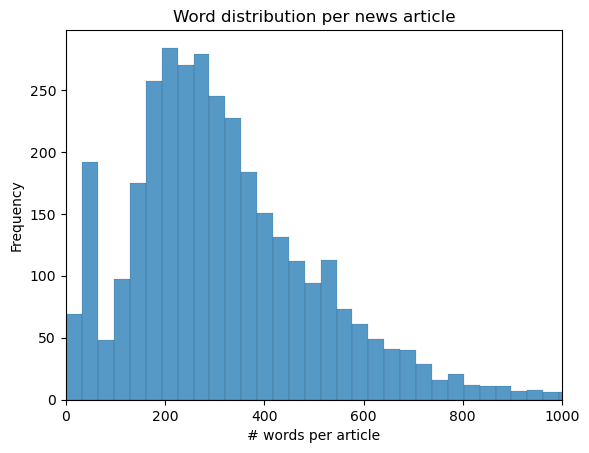

In [18]:
histogram = []
for i, x in df.iterrows():
    text = x.preprocess_text.split()
    count = sum([1 for x in text if x != "[UNK]"])
    histogram.append(count)
        
# the histogram of the data
#_, bins, _ = plt.hist(histogram)
g = sns.histplot(data=histogram)
g.set(xlim=(0, 1000))
g.set_title('Word distribution per news article')
g.set_xlabel('# words per article')
g.set_ylabel('Frequency')
plt.show()

In [27]:
# Calculate percentiles
np.percentile(histogram, [26, 70])

array([199., 399.])

In [28]:
# Calculate mean
np.mean(histogram)

357.82058047493405

In [29]:
# Calculate std
np.std(histogram)

404.4687777093236

In [30]:
# Extract the pre-processed data
columns = ['original_text', 'preprocess_text', 'encoded', 'frames',
           'conflicto', 'economico', 'humanidad', 'moral']

df = np.load("datasets/preprocess_dataset.npy", allow_pickle=True)
df = pd.DataFrame(df, columns=columns)

In [31]:
# Calculate the number of articles with frames
labels_df = df[['conflicto', 'economico', 'humanidad', 'moral']]
print(labels_df.sum(axis=0))

conflicto    1117
economico     550
humanidad    1497
moral         754
dtype: object


In [32]:
# Calculate the percentage of frames distribution
print("\nPercentage\n")
print(100*labels_df.sum(axis=0)/len(df))


Percentage

conflicto    32.746995
economico    16.124304
humanidad    43.887423
moral        22.104955
dtype: object


In [33]:
# Calculate the number of news articles by frame. 
# Since articles can have more than one frame, the sum will be bigger than the actual number of news articles.
labels_df.sum().sum()

3918

In [35]:
# Count the number of articles by article
count_df = df.value_counts(['conflicto', 'economico', 'humanidad', 'moral'])

In [36]:
# Calculate the correlations among frames.
round(labels_df.astype(float).corr(),3)

,conflicto,economico,humanidad,moral
conflicto,1.000,0.024,0.074,0.301
economico,0.024,1.000,-0.058,0.003
humanidad,0.074,-0.058,1.000,0.093
moral,0.301,0.003,0.093,1.000


In [37]:
# Frequency of news articles with 0, 1, 2, 3, and 4 frames
count_frames = df.frames.map(lambda x: sum(x))
print(count_frames.value_counts().sort_index())

0     973
1    1352
2     732
3     314
4      40
Name: frames, dtype: int64


In [38]:
# Percentage of news articles with 0, 1, 2, 3, and 4 frames
print("\nPercentage\n")
print(count_frames.value_counts().sort_index()/count_frames.value_counts().sum())


Percentage

0    0.285254
1    0.396365
2    0.214600
3    0.092055
4    0.011727
Name: frames, dtype: float64


In [39]:
# News article frequency by combination
count_df.sort_index()

conflicto  economico  humanidad  moral
0          0          0          0        973
                                 1        132
                      1          0        701
                                 1        132
           1          0          0        222
                                 1         19
                      1          0         91
                                 1         24
1          0          0          0        297
                                 1        167
                      1          0        259
                                 1        200
           1          0          0         64
                                 1         40
                      1          0         50
                                 1         40
dtype: int64

# Load datasets y calculate embeddings
- FastText
- Elmo
- Beto

In [ ]:
columns = ['original_text', 'preprocess_text', 'encoded', 'frames', 'conflicto', 'economico', 'humanidad', 'moral']

df = np.load("datasets/preprocess_dataset.npy", allow_pickle=True)
df = pd.DataFrame(df, columns=columns)

df.head()

# Embeddings  

## Beto

In [ ]:
import torch
from transformers import BertConfig, BertTokenizer, BertForPreTraining
from torch.utils.data import DataLoader, TensorDataset   

        
class InputFeatures(object):
    """A single set of features of data."""
    def __init__(self, input_ids, input_mask, segment_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids


def convert_example_to_feature(example_row):
    text, max_seq_length, tokenizer, cls_token, sep_token = example_row
    tokens_a = tokenizer.tokenize(text)
    
    # Account for [CLS] and [SEP] with "- 2"
    special_tokens_count = 2
    tokens_a = tokens_a[:(max_seq_length - special_tokens_count)]
    tokens = tokens_a + [sep_token]
    segment_ids = [0] * len(tokens)

    tokens = [cls_token] + tokens
    segment_ids = [0] + segment_ids

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = max_seq_length - len(input_ids)
    
    input_ids = input_ids + ([0] * padding_length)
    input_mask = input_mask + ([0] * padding_length)
    segment_ids = segment_ids + ([0] * padding_length)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
    )


def convert_examples_to_features(texts, max_seq_length, tokenizer, cls_token, sep_token):
    examples = [(text, max_seq_length, tokenizer, cls_token, sep_token) for text in texts]
    return [convert_example_to_feature(example) for example in examples]



class BetoEmbedding:
    def __init__(self, take_mean=True):
        self.tokenizer = BertTokenizer.from_pretrained('vocab.txt', keep_accents=True)
        config = BertConfig.from_json_file('bert_config.json')
        config.output_hidden_states = True
        self.bert = BertForPreTraining.from_pretrained('pytorch_model.bin', config=config)
        for p in self.bert.parameters():
            p.requires_grad = False
            
        self.take_mean = take_mean

    def __call__(self, X):
        
        tokenizer = self.tokenizer
        features = convert_examples_to_features(X, 512, tokenizer, tokenizer.cls_token,tokenizer.sep_token)

        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)

        train_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
        train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
        device = torch.device("cuda")
        
        self.bert.to(device)

        CLS_VECTORS = None

        for batch in train_dataloader:
            input_ids, attention_mask, token_type_ids = tuple(t.to(device) for t in batch)

            outputs = self.bert(input_ids, attention_mask, token_type_ids)
                        
            # outputs[-1] = salidas de las capas ocultas (hidden_iniciales, capa_1, ..., capa_12)
            outputs = outputs[-1][-1] # Tomar de las hidden_state, la última capa

            if self.take_mean:
                output = torch.mean(outputs, 1)
            else:
                output = outputs[:, 0, :] # Tomar el primer vector (CLS)
                
            if CLS_VECTORS is None:
                CLS_VECTORS = output.detach().cpu().numpy()
            else:
                CLS_VECTORS = np.append(CLS_VECTORS, output.detach().cpu().numpy(), axis=0)

        return CLS_VECTORS

In [ ]:
def get_beto_embedding(x):
    torch.manual_seed(4444)
    np.random.seed(4444)
    
    x = np.array([" ".join(text.split(" ")[:510]) for text in x])
    return BetoEmbedding(take_mean=True)(x)

beto_embedding_dataset = get_beto_embedding(df.preprocess_text)

In [ ]:
np.save("datasets/beto_embedding_mean_dataset.npy", beto_embedding_dataset)

In [ ]:
def get_beto_embedding(x):
    torch.manual_seed(4444)
    np.random.seed(4444)
    
    x = np.array([" ".join(text.split(" ")[:510]) for text in x])
    return BetoEmbedding(take_mean=False)(x)


beto_embedding_dataset = get_beto_embedding(df.preprocess_text)

In [ ]:
np.save("datasets/beto_embedding_cls_dataset.npy", beto_embedding_dataset)

## Elmo

In [ ]:
import json
import numpy as np
from ELMoForManyLangs.elmoformanylangs import Embedder

elmo = Embedder('ElMoSpanishEmbedding/')
clear_output()

In [ ]:
original = torch.cuda.is_available

torch.cuda.is_available = lambda :False

In [ ]:
torch.cuda.is_available()

In [ ]:
import logging

# Desabilitamos el logging para que la librería de ELMo no haga prints
logger = logging.getLogger()
logger.disabled = True

def save_elmo(df, filename):
    max_length_text = 512

    total = len(df)
    elmo_embedding = []
    for i, text in enumerate(df.preprocess_text):
        print(f"\r{i}/{total}", end="")

        embedding = elmo.sents2elmo([text.split()[:max_length_text]], output_layer=-1)[0]
        elmo_embedding.append(np.mean(embedding, axis=0))

    data_elmo =  np.array(elmo_embedding)

    # Salvar Elmo Embeddings comprimodo
    np.savez_compressed(f'datasets/{filename}.npz', data_elmo)
    print("")
    
save_elmo(df, "elmo_dataset")

logger.disabled = False

## FastText

In [ ]:
from gensim.models.keyedvectors import KeyedVectors

wordvectors_file_vec = 'embeddings-l-model.vec'
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec)

In [ ]:
# Generamos diccionario de fastText
fastText = {}

import nltk
from nltk.corpus import stopwords  

nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish') + ["[UNK]", "[NUM]"] )


def apply_FastText(text):
    data = []
    for i, word in enumerate(text):
        
        if word in spanish_stopwords:
            continue
            
        if word in wordvectors:
            data.append(wordvectors[word])
            
    return np.mean(np.array(data), axis=0)


def save_fastText(texts, filename):
    total = len(texts)
    fastText_data = []
    
    for i, text in enumerate(texts):
        print(f"\r{i}/{total}", end="")
        embedding = apply_FastText(text.split())
        fastText_data.append(embedding)

    fastText_data =  np.array(fastText_data)

    # Salvar Falstext Embeddings comprimodo
    np.savez_compressed(f'datasets/{filename}.npz', fastText_data)
    print()

save_fastText(df.preprocess_text, "fasttext_dataset")